# Compute lap-wise smoothed rate map for each neuron

In [7]:
from mylib.statistic_test import *
from mazepy.datastruc.neuact import SpikeTrain, TuningCurve, NeuralTrajectory
from mazepy.datastruc.variables import VariableBin
from mylib.calcium.dsp_ms import classify_lap

code_id = "0837 - Lapwise Ratemap Correlation"
loc = join(figpath, "Dsp", code_id)
mkdir(loc)

with open(f2['Trace File'][34], 'rb') as handle:
    trace = pickle.load(handle)

def get_lapwise_ratemap(trace: dict):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    smoothed_map = np.zeros((trace['n_neuron'], 2304, beg_idx.shape[0]), dtype = np.float64)
    
    print(np.unique(routes))
    
    for i in tqdm(range(beg_idx.shape[0])):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = trace['spike_nodes_original'][spike_idx].astype(np.int64)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        rate_map = spike_train.calc_tuning_curve(2304, t_interv_limits=100)
        smoothed_map[:, :, i] = rate_map.to_array() @ trace['Ms'].T
    
    return smoothed_map, routes
    
#smoothed_map, routes = get_lapwise_ratemap(trace)

        E:\Data\FinalResults\Dsp\0837 - Lapwise Ratemap Correlation is already existed!


[0 1 2 3 4 5 6]


100%|██████████| 130/130 [00:00<00:00, 150.68it/s]


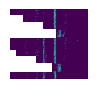

In [17]:
with open(f2['Trace File'][34], 'rb') as handle:
    trace = pickle.load(handle)

def get_lapwise_oldratemap(trace: dict):    
    beg_time, end_time = trace['lap beg time'], trace['lap end time']
    beg_idx = np.array([np.where(trace['correct_time'] >= beg_time[i])[0][0] for i in range(beg_time.shape[0])])
    routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg_idx)
    smoothed_map = np.zeros((trace['n_neuron'], 144, beg_idx.shape[0]), dtype = np.float64)
    
    print(np.unique(routes))
    
    for i in tqdm(range(beg_idx.shape[0])):
        
        spike_idx = np.where(
            (trace['ms_time'] >= beg_time[i]) & (trace['ms_time'] <= end_time[i]) &
            (np.isnan(trace['spike_nodes_original']) == False)
        )[0]
        
        spike_nodes = spike_nodes_transform(trace['spike_nodes_original'][spike_idx].astype(np.int64), 12)-1
        Spikes = trace['Spikes_original'][:, spike_idx]
        
        spike_train = SpikeTrain(
            activity=Spikes,
            time=trace['ms_time'][spike_idx],
            variable=VariableBin(spike_nodes),
        )
        
        rate_map = spike_train.calc_tuning_curve(144, t_interv_limits=100)
        # Mask
        mask_bins = np.setdiff1d(CP_DSP[0], CP_DSP[routes[i]])-1
        rate_map[:, mask_bins] = np.nan
        
        # sort
        cp_bins = CP_DSP[0]
        ip_bins = np.setdiff1d(np.arange(1, 145), cp_bins)
        smoothed_map[:, :cp_bins.shape[0], i] = rate_map[:, cp_bins-1]
        smoothed_map[:, cp_bins.shape[0]:, i] = rate_map[:, ip_bins-1]
    
    return smoothed_map, routes

smoothed_map, routes = get_lapwise_oldratemap(trace)
map9 = smoothed_map[9-1, :, :]

fig = plt.figure(figsize=(1,3))
ax = Clear_Axes(plt.axes())
ax.imshow(map9.T)
plt.savefig(join(loc, "example lapwise rate map - 10232, S7, cell 9.png"), dpi=600)
plt.savefig(join(loc, "example lapwise rate map - 10232, S7, cell 9.svg"), dpi=600)
plt.show()

# Compute Spaital Map Correlation with Route 1 on a lap-wise basis

In [2]:
def get_lapwise_correlation(trace, smoothed_map, routes):
    
    corr = np.zeros(routes.shape[0])
    route_to_nodes = {
        1: 1,
        2: 2,
        3: 3,
        4: 6,
        5: 7,
        6: 8
    }
    for n in tqdm(range(routes.shape[0])):
        i = n
        corr_cell = np.zeros((trace['n_neuron'], 4))
        
        bins = np.intersect1d(
            CP_DSP[routes[i]], CP_DSP[0]
        )
        son_bins = np.concatenate([Father2SonGraph[k] for k in bins])-1
        
        for d, j in enumerate([0, 4, 5, 9]):
            for k in range(trace['n_neuron']):
                corr_cell[k, d] = pearsonr(
                    smoothed_map[k, son_bins, i],
                    trace[f'node {j}']['smooth_map_all'][k, son_bins]
                )[0]
        
        if routes[i] == 0:
            neuron_is_qualified = np.where(
                (trace['node 0']['is_placecell'] == 1) |
                (trace['node 4']['is_placecell'] == 1) |
                (trace['node 5']['is_placecell'] == 1) |
                (trace['node 9']['is_placecell'] == 1)
            )[0]
        else:
            neuron_is_qualified = np.where(
                (trace[f'node {route_to_nodes[routes[i]]}']['is_placecell'] == 1)
            )[0]
        corr[n] = np.nanmean(np.nanmean(corr_cell, axis=1)[neuron_is_qualified])
    return corr

#corr = get_lapwise_correlation(trace, smoothed_map, routes)

In [36]:
def plot(mouse = 10232):
    idx = np.where(f2['MiceID'] == mouse)[0]
    
    corr = []
    route = []
    for i in idx:
        print(f2['Trace File'][i])
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
        smoothed_map, routes = get_lapwise_ratemap(trace)
        corr.append(get_lapwise_correlation(trace, smoothed_map, routes))
        route.append(routes[routes != 0])
    
    corr = np.concatenate(corr)
    route = np.concatenate(route)
    return corr, route

corr, route = plot(mouse = 10232)

E:\Data\Dsp_maze\10232\20241025\trace.pkl
[0 1 2 3 4 5 6]


  0%|          | 0/99 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
100%|██████████| 99/99 [00:08<00:00, 11.86it/s]
0it [00:00, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\12454\AppData\Local\Temp\ipykernel_15336\1058311514.py:23: RuntimeWarning: Mean of empty slice
  corr[n] = np.nanmean(np.nanmean(corr_cell, axis=1))
61it [02:08,  2.10s/it]


E:\Data\Dsp_maze\10232\20241026\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 102/102 [00:06<00:00, 14.99it/s]
62it [01:44,  1.68s/it]


E:\Data\Dsp_maze\10232\20241027\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 100/100 [00:06<00:00, 16.53it/s]
61it [01:34,  1.55s/it]


E:\Data\Dsp_maze\10232\20241028\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 108/108 [00:08<00:00, 12.14it/s]
67it [01:49,  1.64s/it]


E:\Data\Dsp_maze\10232\20241029\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 117/117 [00:07<00:00, 15.00it/s]
71it [01:57,  1.65s/it]


E:\Data\Dsp_maze\10232\20241030\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 120/120 [00:09<00:00, 12.24it/s]
72it [01:43,  1.44s/it]


E:\Data\Dsp_maze\10232\20241031\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 130/130 [00:07<00:00, 16.37it/s]
78it [01:50,  1.42s/it]


In [4]:
if exists(join(figdata, code_id + ' .pkl')) == False:
    Data = {
        "MiceID": [],
        "Correlation": [],
        "Route": [],
        "Training Day": []
    }
    
    for i in tqdm(range(len(f2))):
        with open(f2['Trace File'][i], 'rb') as handle:
            trace = pickle.load(handle)
            
        beg, end = LapSplit(trace, trace['paradigm'])
        routes = classify_lap(spike_nodes_transform(trace['correct_nodes'], 12), beg)
        corr = trace['lapwise_corr']
            
        idx = np.where((routes != 0))[0]
        corr = corr[idx]
        Data['MiceID'].append(np.repeat(f2['MiceID'][i], corr.shape[0]))
        Data['Correlation'].append(corr)
        Data['Route'].append(routes[(routes != 0)])
        Data['Training Day'].append(np.repeat(f2['training_day'][i], corr.shape[0]))
        
    for k in Data.keys():
        Data[k] = np.concatenate(Data[k])
    
    with open(join(figdata, code_id + '.pkl'), 'wb') as handle:
        pickle.dump(Data, handle)
        
    D = pd.DataFrame(Data)
    D.to_excel(join(figdata, code_id + '.xlsx'), index = False)
else:
    with open(join(figdata, code_id + '.pkl'), 'rb') as handle:
        Data = pickle.load(handle)

Data = SubDict(Data, Data.keys(), np.where(Data['MiceID'] != 10209)[0])

100%|██████████| 35/35 [00:38<00:00,  1.10s/it]


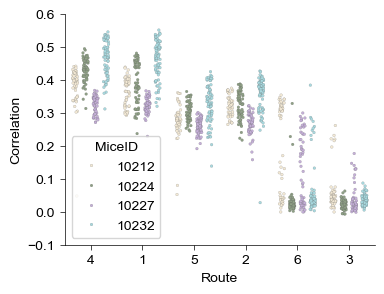

In [5]:
fig = plt.figure(figsize = (4,3))
ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
sns.stripplot(
    x = 'Route',
    y = 'Correlation',
    order=[4, 1, 5, 2, 6, 3],
    data = Data,
    hue = 'MiceID',
    palette = ['#F2E8D4', '#8E9F85', '#C3AED6', '#A7D8DE'],
    size = 2,
    linewidth=0.1,
    dodge=True,
    jitter=0.2,
    ax = ax
)
ax.set_ylim([-0.1, 0.6])
ax.set_yticks(np.linspace(-0.1, 0.6, 8))
plt.savefig(join(loc, "Lapwise Correlation.png"), dpi = 600)
plt.savefig(join(loc, "Lapwise Correlation.svg"), dpi = 600)
plt.show()

e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


10212 [0.114]


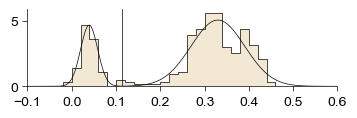

e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


10224 [0.0815]


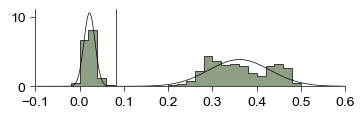

e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


10227 [0.0751]


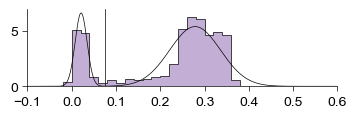

e:\Anaconda\envs\maze\lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


10232 [0.0956]


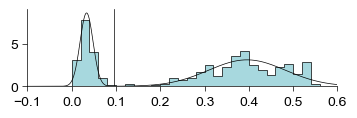

  Mean: 0.09154999999999999, STD: 0.014933268229024745, Max: 0.11399999999999996, Min: 0.07509999999999997, Median: 0.08854999999999999, df: 3


In [6]:
from sklearn.mixture import GaussianMixture
from skimage.filters import threshold_otsu


colors = ['#F2E8D4', '#8E9F85', '#C3AED6', '#A7D8DE']
thres = np.zeros(4)
for i, mice in enumerate(np.unique(Data['MiceID'])):
    idx = np.where((Data['MiceID'] == mice) & (np.isnan(Data['Correlation']) == False))[0]
    
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(Data['Correlation'][idx].reshape(-1, 1))
    x = np.linspace(-0.1, 0.6, 7001)[:, np.newaxis]
    pdf = np.exp(gmm.score_samples(x))
    means = gmm.means_
    min_mean, max_mean = np.min(means), np.max(means)
    min_idx = np.argmin(pdf[np.where((x >= min_mean) & (x <= max_mean))[0]]) + np.where(x >= min_mean)[0][0]
    threshold = x[min_idx]
    print(mice, threshold)
    thres[i] = threshold[0]
    
    fig = plt.figure(figsize = (4,1))
    ax = Clear_Axes(plt.axes(), close_spines=['top', 'right'], ifxticks=True, ifyticks=True)
    ax.hist(
        Data['Correlation'][idx],
        range = [-0.1, 0.6],
        bins = 35,
        histtype='stepfilled',
        color = colors[i],
        linewidth = 0.5,
        density=True,
        edgecolor='k'
    )
    ax.axvline(threshold, color = 'k', linewidth = 0.5)
    ax.plot(x, pdf, color = 'k', linewidth = 0.5)
    ax.set_xlim([-0.1, 0.6])
    ax.set_xticks(np.linspace(-0.1, 0.6, 8))
    plt.savefig(join(loc, f"Lapwise Correlation Histogram [{mice}].png"), dpi = 600)
    plt.savefig(join(loc, f"Lapwise Correlation Histogram [{mice}].svg"), dpi = 600)
    plt.show()
    
print_estimator(thres)

In [3]:
for i in range(len(f2)):
    with open(f2['Trace File'][i], 'rb') as handle:
        trace = pickle.load(handle)
        
    print(f2['Trace File'][i])
        
    smoothed_map, routes = get_lapwise_ratemap(trace)
    corr = get_lapwise_correlation(trace, smoothed_map, routes)
    trace['lapwise_corr_pc'] = corr
    
    with open(f2['Trace File'][i], 'wb') as handle:
        pickle.dump(trace, handle)

E:\Data\Dsp_maze\10209\20230524\trace.pkl
[0 1 2 3 4 5 6]


  0%|          | 0/52 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\mazepy\datastruc\neuact.py:1123: RuntimeWarning: invalid value encountered in divide
  firing_rate = spike_counts/(occu_time/1000)
  0%|          | 0/52 [00:00<?, ?it/s]e:\Anaconda\envs\maze\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\12454\AppData\Local\Temp\ipykernel_24560\2005170711.py:39: RuntimeWarning: Mean of empty slice
  corr[n] = np.nanmean(np.nanmean(corr_cell, axis=1)[neuron_is_qualified])
100%|██████████| 52/52 [00:20<00:00,  2.54it/s]


E:\Data\Dsp_maze\10212\20230524\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 52/52 [00:23<00:00,  2.24it/s]


E:\Data\Dsp_maze\10209\20230526\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 61/61 [00:19<00:00,  3.10it/s]


E:\Data\Dsp_maze\10212\20230526\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 60/60 [00:28<00:00,  2.14it/s]


E:\Data\Dsp_maze\10209\20230528\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 69/69 [00:30<00:00,  2.25it/s]


E:\Data\Dsp_maze\10212\20230528\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 74/74 [00:42<00:00,  1.76it/s]


E:\Data\Dsp_maze\10209\20230529\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 65/65 [00:32<00:00,  1.98it/s]


E:\Data\Dsp_maze\10212\20230529\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 82/82 [00:40<00:00,  2.03it/s]


E:\Data\Dsp_maze\10209\20230530\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 60/60 [00:19<00:00,  3.05it/s]


E:\Data\Dsp_maze\10212\20230530\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 80/80 [00:36<00:00,  2.21it/s]


E:\Data\Dsp_maze\10209\20230601\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 75/75 [00:20<00:00,  3.70it/s]


E:\Data\Dsp_maze\10212\20230601\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 101/101 [00:46<00:00,  2.17it/s]


E:\Data\Dsp_maze\10209\20230602\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 80/80 [00:24<00:00,  3.20it/s]


E:\Data\Dsp_maze\10212\20230602\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


E:\Data\Dsp_maze\10224\20231009\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 89/89 [00:59<00:00,  1.49it/s]


E:\Data\Dsp_maze\10227\20231009\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 68/68 [01:08<00:00,  1.00s/it]


E:\Data\Dsp_maze\10224\20231010\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 92/92 [00:52<00:00,  1.77it/s]


E:\Data\Dsp_maze\10227\20231010\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 88/88 [01:22<00:00,  1.06it/s]


E:\Data\Dsp_maze\10224\20231011\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 89/89 [00:51<00:00,  1.73it/s]


E:\Data\Dsp_maze\10227\20231011\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 83/83 [01:07<00:00,  1.23it/s]


E:\Data\Dsp_maze\10224\20231012\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 97/97 [00:59<00:00,  1.64it/s]


E:\Data\Dsp_maze\10227\20231012\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 93/93 [01:53<00:00,  1.22s/it]


E:\Data\Dsp_maze\10224\20231013\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 99/99 [01:24<00:00,  1.17it/s]


E:\Data\Dsp_maze\10227\20231013\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 92/92 [01:22<00:00,  1.11it/s]


E:\Data\Dsp_maze\10224\20231014\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


E:\Data\Dsp_maze\10227\20231014\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


E:\Data\Dsp_maze\10224\20231015\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 101/101 [00:53<00:00,  1.90it/s]


E:\Data\Dsp_maze\10227\20231015\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 95/95 [01:15<00:00,  1.25it/s]


E:\Data\Dsp_maze\10232\20241025\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 99/99 [01:30<00:00,  1.10it/s]


E:\Data\Dsp_maze\10232\20241026\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 102/102 [01:14<00:00,  1.38it/s]


E:\Data\Dsp_maze\10232\20241027\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


E:\Data\Dsp_maze\10232\20241028\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 108/108 [01:11<00:00,  1.51it/s]


E:\Data\Dsp_maze\10232\20241029\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 117/117 [01:22<00:00,  1.41it/s]


E:\Data\Dsp_maze\10232\20241030\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 120/120 [01:12<00:00,  1.65it/s]


E:\Data\Dsp_maze\10232\20241031\trace.pkl
[0 1 2 3 4 5 6]


100%|██████████| 130/130 [01:11<00:00,  1.83it/s]
